## Keras -- MLPs on MNIST

In [2]:
# if you keras is not using tensorflow as backend set "KERAS_BACKEND=tensorflow" use this command
import warnings
warnings.filterwarnings("ignore")
from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers import Dropout
from keras.initializers import he_normal

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [4]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of training examples : 10000 and each image is of shape (28, 28)


In [9]:
# if you observe the input shape its 2 dimensional vector
# for each image we have a (28*28) vector
# we will convert the (28*28) vector into single dimensional vector of 1 * 784 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

In [10]:
# after converting the input images from 3d to 2d vectors

print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d)"%(X_train.shape[1]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d)"%(X_test.shape[1]))

Number of training examples : 60000 and each image is of shape (784)
Number of training examples : 10000 and each image is of shape (784)


In [11]:
# An example data point
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

### Normalizing the data

In [12]:
# if we observe the above matrix each cell is having a value between 0-255
# before we move to apply machine learning algorithms lets try to normalize the data
# X => (X - Xmin)/(Xmax-Xmin) = X/255

X_train = X_train/255
X_test = X_test/255

In [13]:
# example data point after normlizing
print(X_train[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

### Vectorizing the class label to 10 dimensions

In [14]:
# here we are having a class number for each image
print("Class label of first image :", y_train[0])

# lets convert this into a 10 dimensional vector
# ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
# this conversion needed for MLPs 

Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

print("After converting the output into a vector : ",Y_train[0])

Class label of first image : 5
After converting the output into a vector :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### some model parameters

In [15]:
output_dim = 10
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 20

## Model 1; 2 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer

In [16]:
# start building a model
model_relu = Sequential()
model_relu.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.062,seed=None)))
model_relu.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.125,seed=None)))
model_relu.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_relu.summary())

model_relu.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_relu.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 68us/step - loss: 0.2206 - acc: 0.9336 - val_loss: 0.1176 - val_acc: 0.9621
Epoch 2/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.0798 - 

## Model 1; 2 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer
### Result 
  - accuracy = 99.81 %

### Plotting Epoch vs Loss

Test score: 0.11215360218922174
Test accuracy: 0.9777


<IPython.core.display.Javascript object>


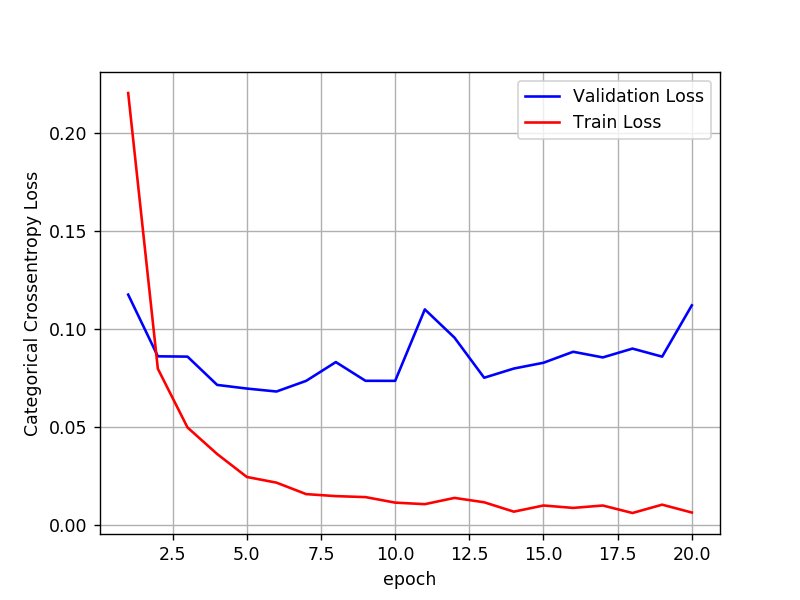

In [21]:
score = model_relu.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer

In [23]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_batch = Sequential()
model_batch.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.062,seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.125,seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_batch.summary())

model_batch.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_batch.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 538,890
Trainable params: 537,354
Non-trainable params: 1,536
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 92us/step - loss

## Model 1; 2 Hidden Layers
### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer
### Result 
  - accuracy = 99.74 %

### Plotting Epoch vs Loss

Test score: 0.08021026619893437
Test accuracy: 0.9818


<IPython.core.display.Javascript object>


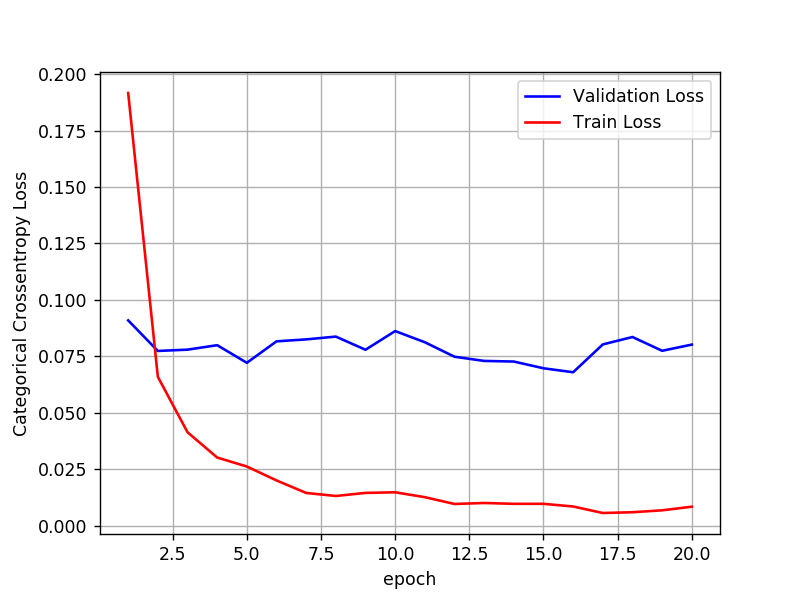

In [24]:
score = model_batch.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.5) + ADAMOptimizer

In [25]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.062,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.125,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
___________________________

## Model 1; 2 Hidden Layers
### MLP + Batch Normalization + Dropout(0.5) + ADAMOptimizer
### Result 
  - accuracy = 98.35 %

### Plotting Epoch vs Loss

Test score: 0.053079094627026646
Test accuracy: 0.9844


<IPython.core.display.Javascript object>


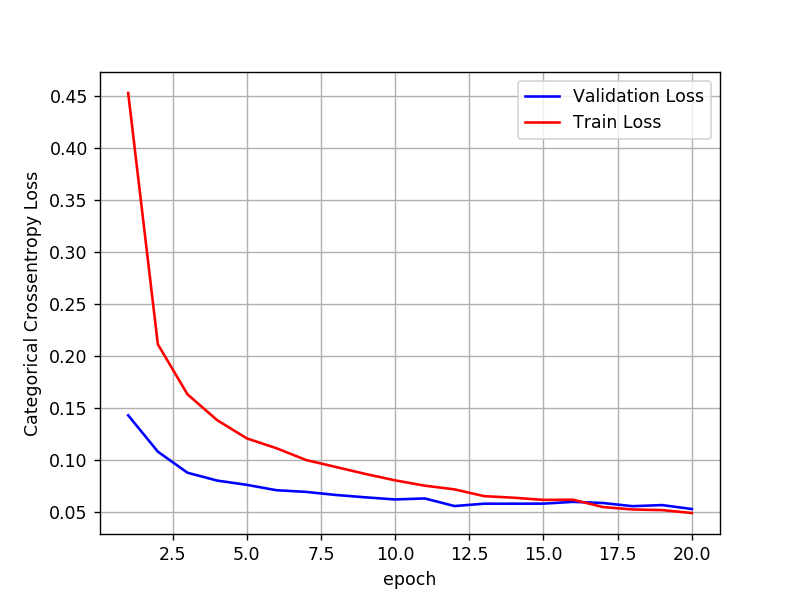

In [26]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.1) + ADAMOptimizer

In [27]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.062,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.125,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total para

## Model 1; 2 Hidden Layers
### MLP + Batch Normalization + Dropout(0.1) + ADAMOptimizer
### Result 
  - accuracy = 99.72 %

### Plotting Epoch vs Loss

Test score: 0.07680374337043286
Test accuracy: 0.9818


<IPython.core.display.Javascript object>


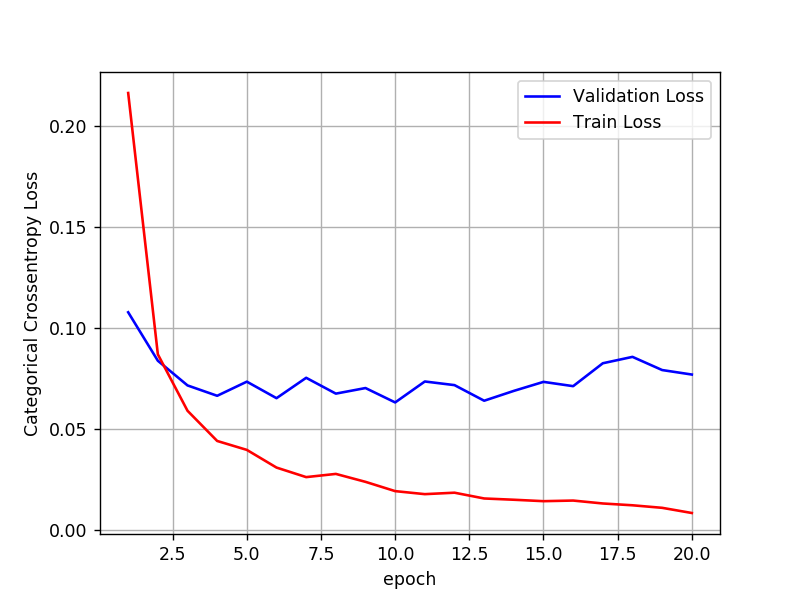

In [28]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.9) + ADAMOptimizer

In [29]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.062,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = RandomNormal(mean=0.0,stddev=0.125,seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total para

## Model 1; 2 Hidden Layers
### MLP + Batch Normalization + Dropout(0.9) + ADAMOptimizer
### Result 
  - accuracy = 89.77 %

### Plotting Epoch vs Loss

Test score: 0.15648084507249296
Test accuracy: 0.9544


<IPython.core.display.Javascript object>


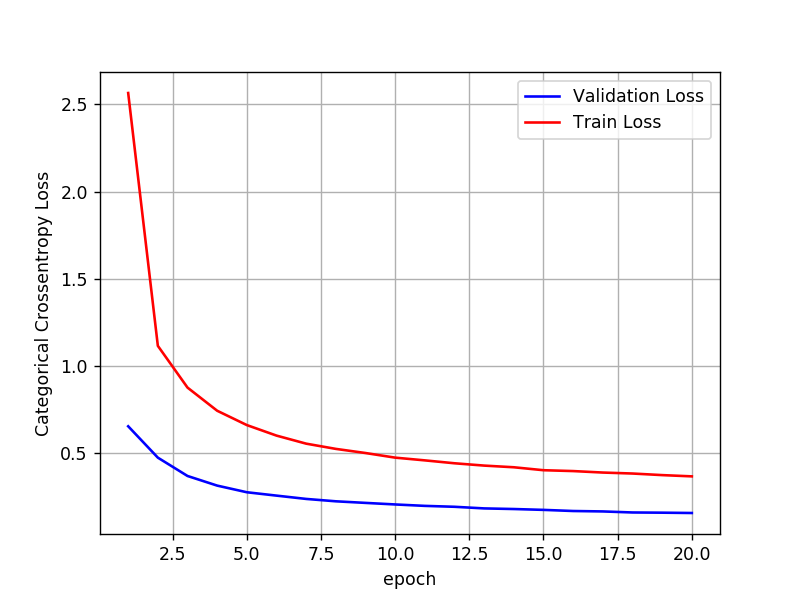

In [30]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

## Model 2; 3 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer

In [31]:
# start building a model
model_relu = Sequential()
model_relu.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_relu.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_relu.summary())

model_relu.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_relu.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.2211 - acc: 0.9340 - val_loss: 0.1027 - val_acc: 0.9676
Epoch 2/20
60000/60000 [==============================] - 5s 75us/step - los

## Model 2; 3 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer
### Result 
  - accuracy = 97.95 %

### Plotting Epoch vs Loss

Test score: 0.09801716504239671
Test accuracy: 0.9795


<IPython.core.display.Javascript object>


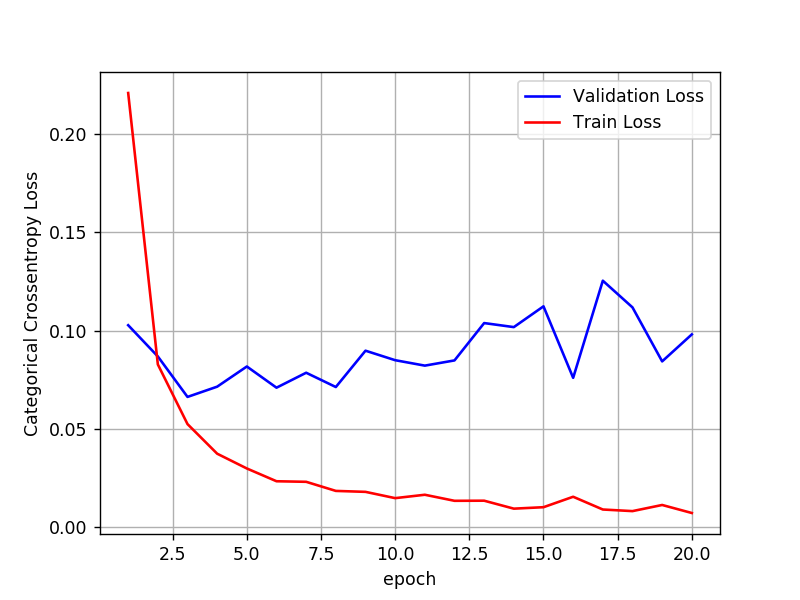

In [32]:
score = model_relu.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer

In [33]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_batch = Sequential()
model_batch.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_batch.summary())

model_batch.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_batch.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
Total para

## Model 2; 3 Hidden Layers
### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer
### Result 
  - accuracy = 98.38 %

### Plotting Epoch vs Loss

Test score: 0.0696980723319808
Test accuracy: 0.9838


<IPython.core.display.Javascript object>


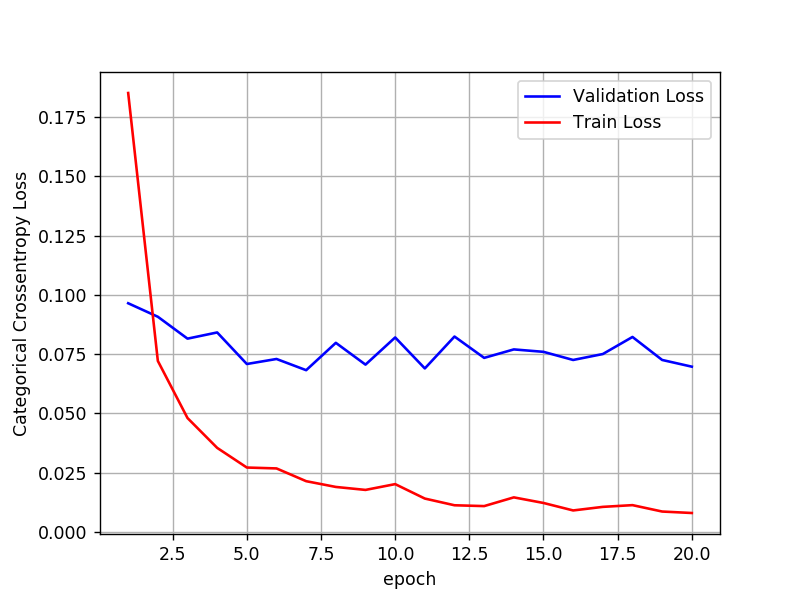

In [34]:
score = model_batch.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.5) + ADAMOptimizer

In [35]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
__________

## Model 2; 3 Hidden Layers
### MLP + Batch Normalization + Dropout(0.5) + ADAMOptimizer
### Result 
  - accuracy = 98.31 %

### Plotting Epoch vs Loss

Test score: 0.06120688360746717
Test accuracy: 0.9831


<IPython.core.display.Javascript object>


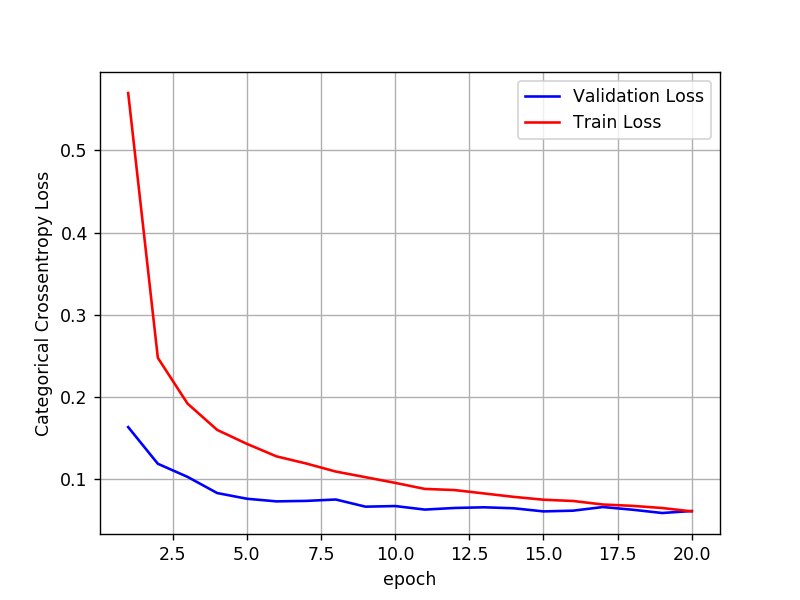

In [36]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.1) + ADAMOptimizer

In [37]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
__________

## Model 2; 3 Hidden Layers
### MLP + Batch Normalization + Dropout(0.1) + ADAMOptimizer
### Result 
  - accuracy = 98.50 %

### Plotting Epoch vs Loss

Test score: 0.059629298784493585
Test accuracy: 0.985


<IPython.core.display.Javascript object>


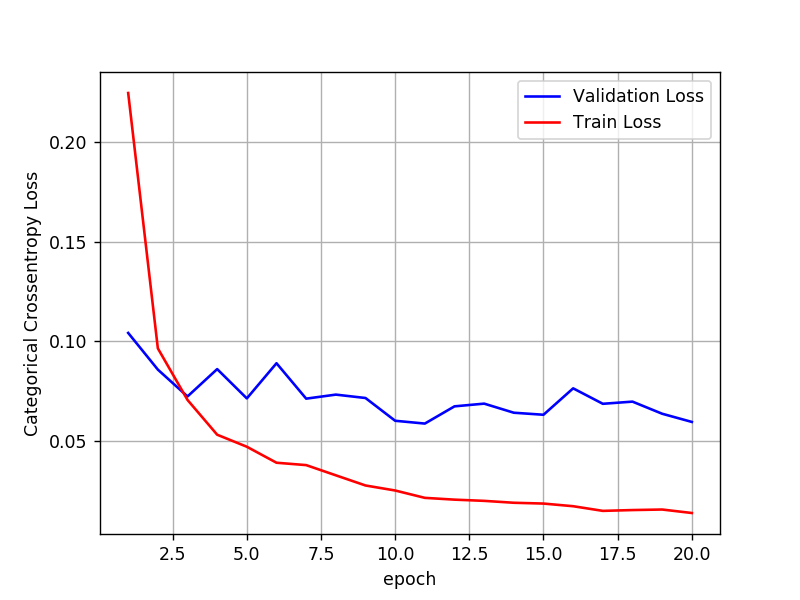

In [38]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.9) + ADAMOptimizer

In [39]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
__________

## Model 2; 3 Hidden Layers
### MLP + Batch Normalization + Dropout(0.9) + ADAMOptimizer
### Result 
  - accuracy = 93.53 %

### Plotting Epoch vs Loss

Test score: 0.27690330274105074
Test accuracy: 0.9353


<IPython.core.display.Javascript object>


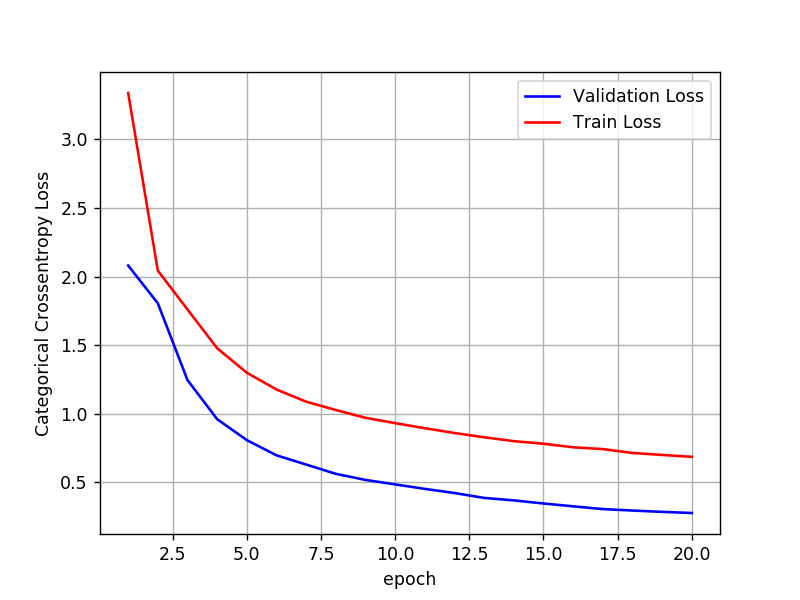

In [40]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

## Model 3; 5 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer

In [42]:
# start building a model
model_relu = Sequential()
model_relu.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(64,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))
model_relu.add(Dense(32,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_relu.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_relu.summary())

model_relu.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_relu.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_46 (Dense)             (None, 10)                330       
Total params: 576,810
Trainable params: 576,810
Non-trainable params: 0
_________________________________________________________________
None

## Model 3; 5 Hidden Layers
### MLP + ReLu Activation + ADAMOptimizer
### Result 
  - accuracy = 99.78 %

### Plotting Epoch vs Loss

Test score: 0.09262571817817825
Test accuracy: 0.9803


<IPython.core.display.Javascript object>


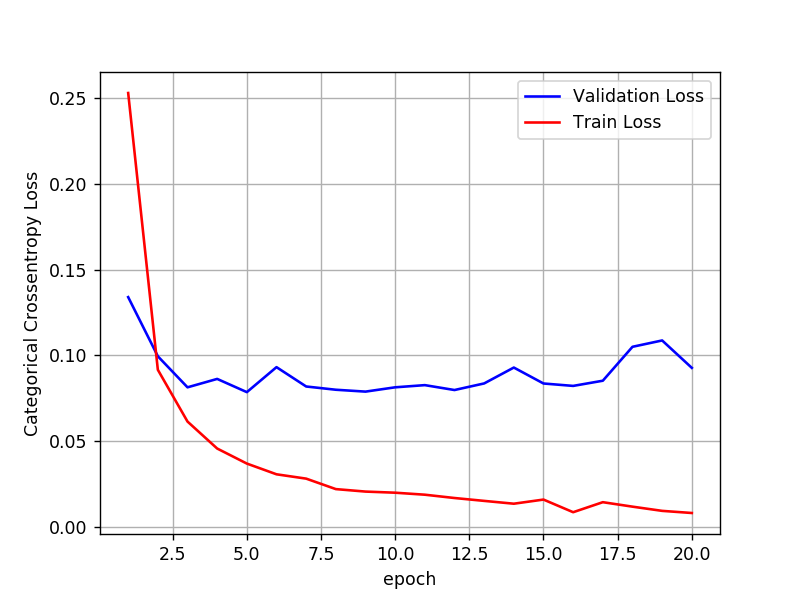

In [43]:
score = model_relu.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer

In [44]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_batch = Sequential()
model_batch.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(64,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(32,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_batch.add(BatchNormalization())

model_batch.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_batch.summary())

model_batch.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_batch.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_48 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
dense_49 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
__________

## Model 3; 5 Hidden Layers
### MLP + Batch Normalization on Hidden Layers + ADAMOptimizer
### Result 
  - accuracy = 99.66 %

### Plotting Epoch vs Loss

Test score: 0.0879675512639893
Test accuracy: 0.979


<IPython.core.display.Javascript object>


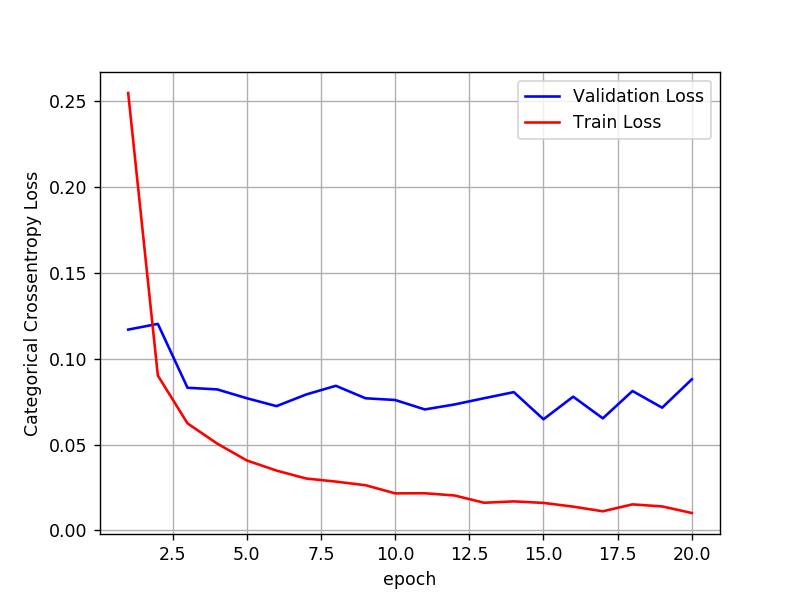

In [45]:
score = model_batch.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.5) + ADAMOptimizer

In [46]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(64,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(32,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.5))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
__________

## Model 3; 5 Hidden Layers
### MLP + Batch Normalization + Dropout(0.5) + ADAMOptimizer
### Result 
  - accuracy = 97.05 %

### Plotting Epoch vs Loss

Test score: 0.08127810045094229
Test accuracy: 0.9804


<IPython.core.display.Javascript object>


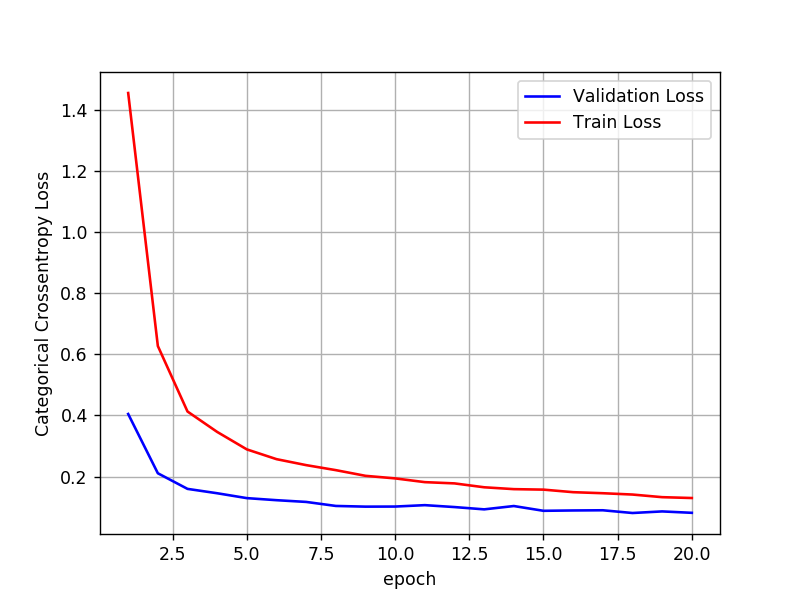

In [47]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.1) + ADAMOptimizer

In [48]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(64,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(32,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.1))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               32896     
__________

## Model 3; 5 Hidden Layers
### MLP + Batch Normalization + Dropout(0.1) + ADAMOptimizer
### Result 
  - accuracy = 99.28 %

### Plotting Epoch vs Loss

Test score: 0.06673984220647836
Test accuracy: 0.9836


<IPython.core.display.Javascript object>


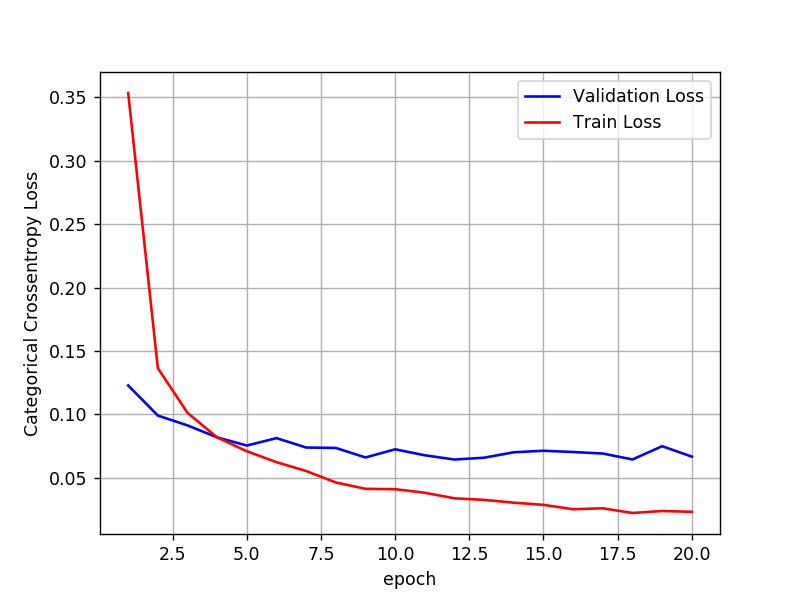

In [49]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### MLP + Batch Normalization +Dropout(0.9) + ADAMOptimizer

In [50]:
from keras.layers.normalization import BatchNormalization
# start building a model
model_drop = Sequential()
model_drop.add(Dense(512,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(256,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(128,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(64,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(32,activation='relu',input_shape=(input_dim,),
                     kernel_initializer = he_normal(seed=None)))

model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.9))

model_drop.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))

print(model_drop.summary())

model_drop.compile(optimizer = 'adam',  loss = 'categorical_crossentropy',metrics=['accuracy'])

result = model_drop.fit(X_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose = 1,
                        validation_data = (X_test,Y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_39 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               32896     
__________

## Model 3; 5 Hidden Layers
### MLP + Batch Normalization + Dropout(0.9) + ADAMOptimizer
### Result 
  - accuracy = 21.62 %

### Plotting Epoch vs Loss

Test score: 1.824279292869568
Test accuracy: 0.2924


<IPython.core.display.Javascript object>


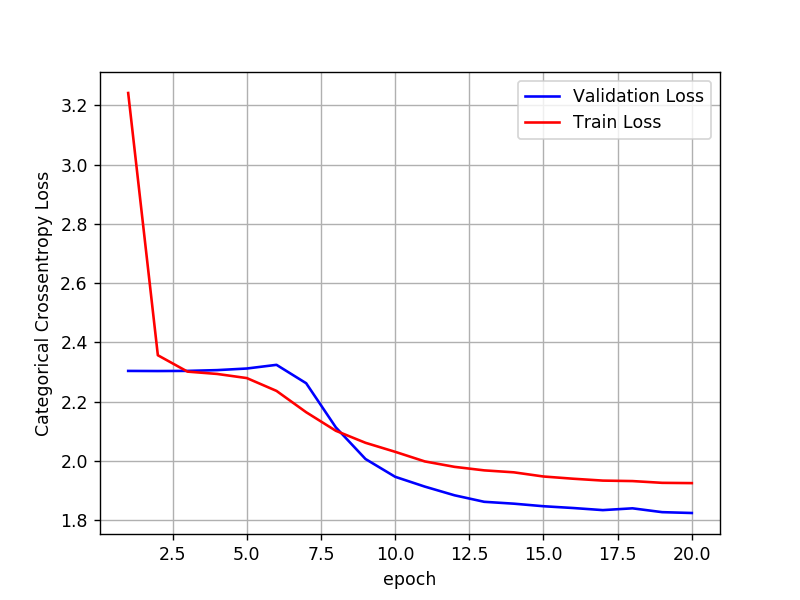

In [51]:
score = model_drop.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))



vy = result.history['val_loss']
ty = result.history['loss']
plt_dynamic(x, vy, ty, ax)

### Pretty Table

In [52]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["No. of Hidden Layers Used", "Activation Unit","Optimiser", "Batch Normalisation", "DropOuts"," Train Accuracy","Test_Accuracy"]

x.add_row(["2", "ReLU","Adam","No","No" ,"99.81%", "97.77%"])
x.add_row(["2", "ReLU","Adam","Yes","No" ,"99.74%", "98.18%"])
x.add_row(["2", "ReLU","Adam","Yes","0.5" ,"98.35%", "98.44%"])
x.add_row(["2", "ReLU","Adam","Yes","0.1" ,"99.72%", "98.18%"])
x.add_row(["2", "ReLU","Adam","Yes","0.9" ,"89.77%", "95.44%"])

x.add_row(["3", "ReLU","Adam","No","No", "99.77%", "97.95%"])
x.add_row(["3", "ReLU","Adam","Yes","No" ,"99.76%", "98.38%"])
x.add_row(["3", "ReLU","Adam","Yes","0.5","98.12%", "98.31%"])
x.add_row(["3", "ReLU","Adam","Yes","0.1" ,"99.53%", "98.50%"])
x.add_row(["3", "ReLU","Adam","Yes","0.9" ,"79.41%", "93.53%"])

x.add_row(["5", "ReLU","Adam","No","No" ,"99.78%", "98.03%"])
x.add_row(["5", "ReLU","Adam","Yes","No" ,"99.66%", "97.90%"])
x.add_row(["5", "ReLU","Adam","Yes","0.5" ,"97.05%", "98.04%"])
x.add_row(["5", "ReLU","Adam","Yes","0.1" ,"99.28%", "98.36%"])
x.add_row(["5", "ReLU","Adam","Yes","0.9" ,"21.62%", "29.24%"])


print(x)

+---------------------------+-----------------+-----------+---------------------+----------+-----------------+---------------+
| No. of Hidden Layers Used | Activation Unit | Optimiser | Batch Normalisation | DropOuts |  Train Accuracy | Test_Accuracy |
+---------------------------+-----------------+-----------+---------------------+----------+-----------------+---------------+
|             2             |       ReLU      |    Adam   |          No         |    No    |      99.81%     |     97.77%    |
|             2             |       ReLU      |    Adam   |         Yes         |    No    |      99.74%     |     98.18%    |
|             2             |       ReLU      |    Adam   |         Yes         |   0.5    |      98.35%     |     98.44%    |
|             2             |       ReLU      |    Adam   |         Yes         |   0.1    |      99.72%     |     98.18%    |
|             2             |       ReLU      |    Adam   |         Yes         |   0.9    |      89.77%     | 